# Amazon Beauty Product Analysis

Installing packages

In [ ]:
!pip install wordcloud

In [ ]:
!pip install matplotlib

Loading packages

In [25]:
from pyspark.sql import SparkSession
import os
import numpy
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize 
import html
import string
import nltk
nltk.download('wordnet')
import string
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import udf
from pyspark.sql.functions import year, avg, desc, row_number
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import col, year, to_date
import statsmodels.api as sm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pyspark.sql.functions import col, count, when
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import col
from pyspark.sql.functions import avg, count, desc
import numpy as np
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.sql.functions import desc
from pyspark.sql.types import ArrayType, FloatType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.sql.types import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import udf, col, size
from pyspark.sql.types import ArrayType, StringType
import itertools
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.ml.classification import NaiveBayes
from pyspark.sql.functions import year, to_date, count
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import ArrayType, StringType
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

[nltk_data] Downloading package wordnet to
[nltk_data]     /usr/local/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Eliminating warning signs

In [26]:
spark = SparkSession.builder \
    .appName("YourAppName") \
    .getOrCreate()
logger = spark._jvm.org.apache.log4j.LogManager.getLogger("org.apache.spark.scheduler.DAGScheduler")
logger.setLevel(spark._jvm.org.apache.log4j.Level.ERROR)

In [27]:
os.environ['NLTK_DATA'] = '/usr/local/share/nltk_data'

Loading the required dataset

In [7]:
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Beauty_v1_00.tsv.gz
!gunzip amazon_reviews_us_Beauty_v1_00.tsv.gz
!hadoop fs -put amazon_reviews_us_Beauty_v1_00.tsv /

--2023-04-26 16:00:00--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Beauty_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.192.160, 52.217.65.238, 52.217.224.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.192.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914070021 (872M) [application/x-gzip]
Saving to: ‘amazon_reviews_us_Beauty_v1_00.tsv.gz.1’

amazon_reviews_us_B 100%[===================>] 871.72M  32.7MB/s    in 28s     

2023-04-26 16:00:29 (31.2 MB/s) - ‘amazon_reviews_us_Beauty_v1_00.tsv.gz.1’ saved [914070021/914070021]



Defining the schema and loading the data into the schema

In [119]:
schema = StructType([
    StructField("marketplace", StringType(), True),
    StructField("customer_id", StringType(), True),
    StructField("review_id", StringType(), True),
    StructField("product_id", StringType(), True),
    StructField("product_parent", StringType(), True),
    StructField("product_title", StringType(), True),
    StructField("product_category", StringType(), True),
    StructField("star_rating", IntegerType(), True),
    StructField("helpful_votes", IntegerType(), True),
    StructField("total_votes", IntegerType(), True),
    StructField("vine", StringType(), True),
    StructField("verified_purchase", StringType(), True),
    StructField("review_headline", StringType(), True),
    StructField("review_body", StringType(), True),
    StructField("review_date", StringType(), True)
])

amazon_data = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("delimiter", "\t") \
    .schema(schema) \
    .load("hdfs://st446-cluster-m:8020/amazon_reviews_us_Beauty_v1_00.tsv")

In [120]:
amazon_data.count()

5115666

In [124]:
amazon_data.na.drop().count()

5114733

## Exploratorary Data Analysis

##### Most popular product for each year

Creating a function to extract year from the review_date

In [44]:
def year(review_date):
    if review_date:
        return int(review_date[:4])
    return None

year_function = udf(year, IntegerType())

Adding a new column for year and then only selecting the required columns the counting the unique product ids repeated for each year

In [48]:
amazon_rdd = amazon_data.withColumn("year", year_function("review_date")).select("product_title", "product_id", "year").rdd

rdd1 = amazon_rdd.map(lambda x: ((x["product_title"], x["product_id"], x["year"]), 1)).reduceByKey(lambda x, y: x + y)

pop_product = rdd1.map(lambda x: (x[0][2], (x[1], x[0][0], x[0][1]))).reduceByKey(lambda x, y: x if x[0] > y[0] else y)

pop_product.take(10)

[(None,
  (7,
   'Aria Starr Beauty ORGANIC Argan Oil (4 OZ) For Hair, Skin, Face, Nails, Beard & Cuticles - Best 100% Pure Moroccan Anti Aging, Anti Wrinkle Beauty Secret, EcoCert Certified Cold Pressed Moisturizer',
   'B00GMAWI66')),
 (2006,
  (151,
   'Rejuvinol (AM) / Rejuvox (PM) - Botox Alternative! Moisturizing & Replenishing Anti-Wrinkle and Line Corrector',
   'B00080M1OK')),
 (2007,
  (309,
   'Waterpik Waterpik Ultra Dental Water Jet Flosser Wp-100',
   'B000GLRREU')),
 (2008,
  (414,
   'Waterpik Waterpik Ultra Dental Water Jet Flosser Wp-100',
   'B000GLRREU')),
 (2009,
  (333, 'Braun 5270 Xelle Silk-Epil Epilator Model: 5395', 'B000EZYKTS')),
 (2010,
  (444,
   'Waterpik Waterpik Ultra Dental Water Jet Flosser Wp-100',
   'B000GLRREU')),
 (2011,
  (577,
   'Waterpik Waterpik Ultra Dental Water Jet Flosser Wp-100',
   'B000GLRREU')),
 (2012,
  (1787,
   'HSI Professional Glider | Ceramic Tourmaline Ionic Flat Iron Hair Straightener | Straightens & Curls with Adjustable Te

In [10]:
# Taking invalid star ratings out of our dataset 
amazon_data = amazon_data.filter(F.col("star_rating").cast("int").isNotNull()) 

ratings_df = amazon_data.groupBy("star_rating").count().withColumnRenamed("count","num_ratings")
ratings_df.show()

+-----------+-----------+
|star_rating|num_ratings|
+-----------+-----------+
|          1|     456885|
|          3|     398395|
|          5|    3254753|
|          4|     741410|
|          2|     264009|
+-----------+-----------+



##### Number of each ratings and plotting them

In [68]:
amazon_rdd = amazon_data.rdd
rating = amazon_rdd.map(lambda x: x[7]).map(lambda x: (x, 1)).reduceByKey(lambda x, y: x + y)

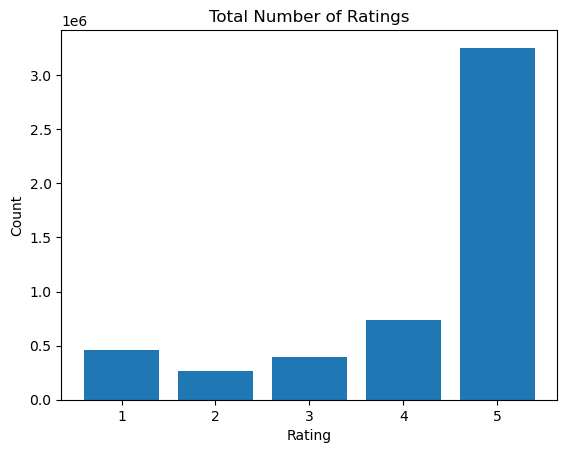

In [70]:
rating = rating.collect()[1:]

rat = [x[0] for x in rating]
number = [x[1] for x in rating]

plt.bar(rat, number)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Total Number of Ratings")
plt.show()

###### Reviews per product

Top 5 products with highest number of reviews

In [80]:
review_number = amazon_data.groupBy("product_id").count().withColumnRenamed("count","product_reviews").sort("product_reviews",ascending=False)
products = spark.createDataFrame(review_number.take(5))
products.show()

+----------+---------------+
|product_id|product_reviews|
+----------+---------------+
|B001MA0QY2|          15565|
|B000GLRREU|           7272|
|B0049LUI9O|           7166|
|B000JNQSIQ|           5227|
|B003WR3QSG|           5079|
+----------+---------------+



Name of the top product

In [77]:
products.join(amazon_data,"product_id","left").select("product_id","product_title").show(1)

+----------+--------------------+
|product_id|       product_title|
+----------+--------------------+
|B001MA0QY2|HSI Professional ...|
+----------+--------------------+
only showing top 1 row



Summary statistics for product reviews

In [81]:
review_number.select('product_reviews').summary().show()

+-------+------------------+
|summary|   product_reviews|
+-------+------------------+
|  count|            588817|
|   mean|  8.68804059665397|
| stddev|53.101841295328946|
|    min|                 1|
|    25%|                 1|
|    50%|                 2|
|    75%|                 4|
|    max|             15565|
+-------+------------------+



###### Reviews per customer

In [82]:
consumer = amazon_data.groupBy('customer_id').count().withColumnRenamed("count", "no_customer_reviews")
consumer.show()

+-----------+-------------------+
|customer_id|no_customer_reviews|
+-----------+-------------------+
|   16267053|                  4|
|   51567583|                  1|
|   21690666|                  1|
|   49032253|                  2|
|    4407387|                  3|
|   37656111|                  1|
|   11285323|                  2|
|   14808510|                  5|
|   32451759|                  5|
|   43593623|                  1|
|   13902025|                  1|
|   47173161|                  3|
|   25139931|                 12|
|   14080250|                  1|
|   33236538|                  2|
|   15195821|                  3|
|   52796426|                  5|
|   25422050|                  4|
|    2711142|                  1|
|   44535462|                  2|
+-----------+-------------------+
only showing top 20 rows



top 10 customers

In [ ]:
top = consumer.sort("no_customer_reviews",ascending=False)
top = spark.createDataFrame(top.take(5))
top.show()

+-----------+-------------------+
|customer_id|no_customer_reviews|
+-----------+-------------------+
|   36771761|                871|
|   32405532|                721|
|   10942711|                685|
|   37446839|                587|
|   50199793|                564|
+-----------+-------------------+



summary statistics for customer 

In [88]:
summary = amazon_data.rdd.map(lambda x: (x['customer_id'], 1)).reduceByKey(lambda x, y: x + y).map(lambda x: x[1]).stats()
print(summary)

(count: 2816378, mean: 1.8163989350861243, stdev: 2.904365662757436, max: 871.0, min: 1.0)


###### Most helpful customers

In [20]:
helpful = amazon_data.rdd.map(lambda x: (x['customer_id'], x['helpful_votes'])).reduceByKey(lambda x, y: x + y).takeOrdered(5, key=lambda x: -x[1])
print(helpful)

[('14425763', 13364), ('18267561', 10649), ('43552412', 6478), ('51918881', 5792), ('17538553', 5751)]


###### Most loyal customers for each year

In [21]:
loyal = amazon_data.rdd.map(lambda x: ((x['customer_id'], x['review_year']), 1)).reduceByKey(lambda x, y: x + y).takeOrdered(5, key=lambda x: -x[1])
print(loyal)

[(('36771761', 2014), 594), (('12201275', 2015), 478), (('10942711', 2015), 385), (('32405532', 2014), 320), (('37446839', 2014), 295)]


##### Verified vs. unverified purchases

In [22]:
verified = amazon_data.rdd.map(lambda x: (x['verified_purchase'], 1)).reduceByKey(lambda x, y: x + y)
distribution = verified.map(lambda x: (x[0], x[1], (x[1] / verified_purchase_rdd.map(lambda x: x[1]).sum()) * 100))
print(distribution.collect())

[('Y', 4230196, 82.69447157357746), ('N', 885256, 17.305528426422534)]


##### Time Series Analysis 

Decomposition

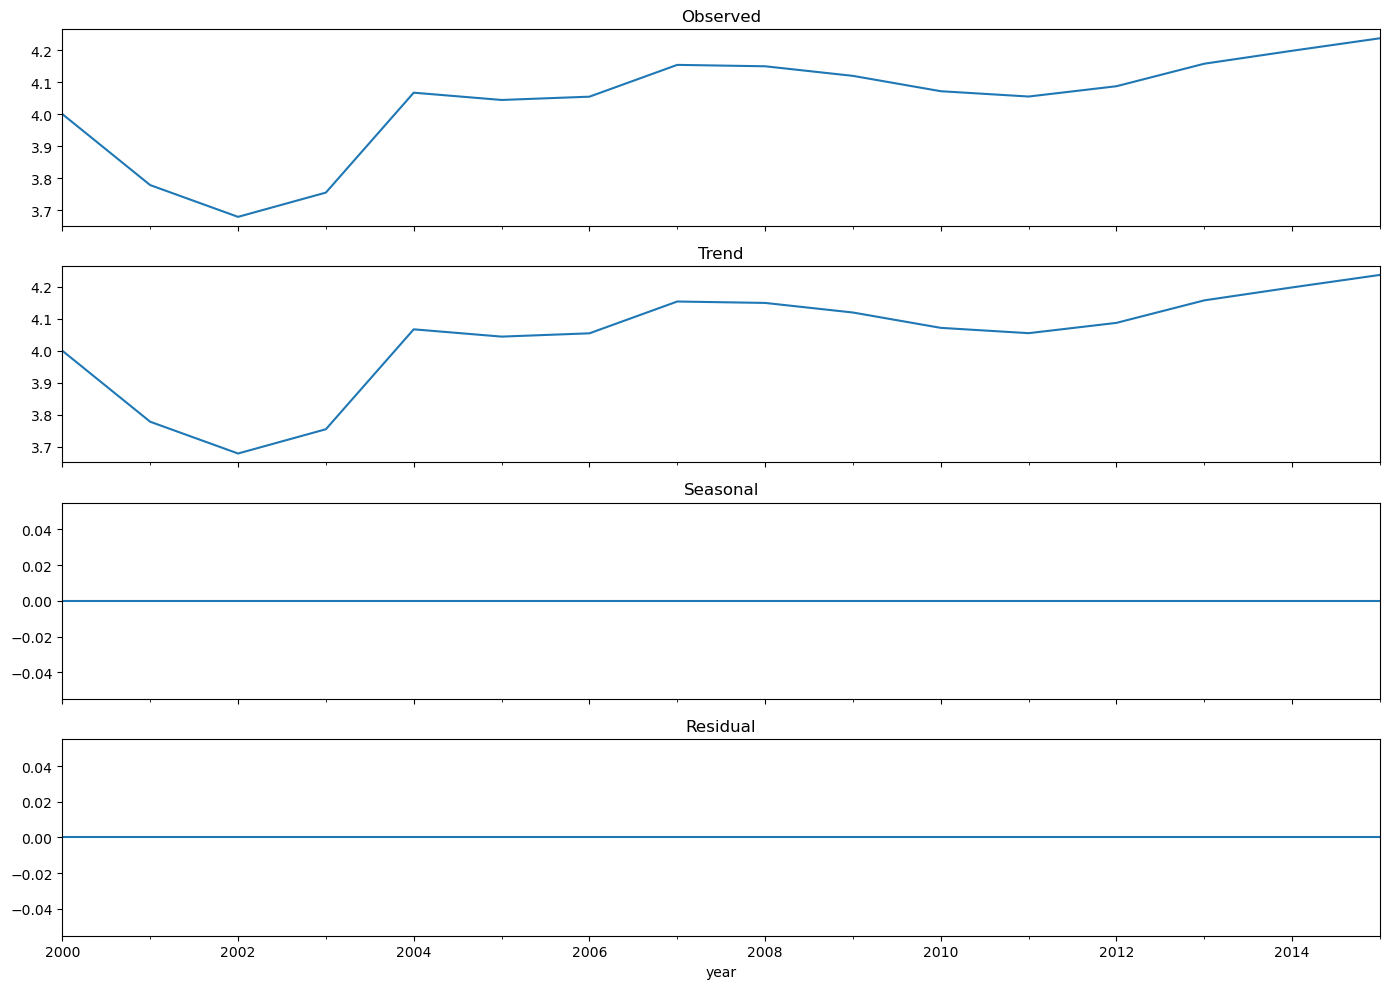

In [11]:
pd = average_ratings_by_year.toPandas()
pd['year'] = pd.to_datetime(pd['year'], format='%Y').set_index('year', inplace=True)
f = 1

d = sm.tsa.seasonal_decompose(pd, model='additive', period=f)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
d.observed.plot(ax=axes[0], title='Observed')
d.trend.plot(ax=axes[1], title='Trend')
d.seasonal.plot(ax=axes[2], title='Seasonal')
d.resid.plot(ax=axes[3], title='Residual')
plt.tight_layout()
plt.show()

## Sentiment Analysis

In [99]:
analyzer = SentimentIntensityAnalyzer()

def score(text):
    return analyzer.polarity_scores(text)['compound']

score = udf(score, FloatType())

In [100]:
sentiment_data = amazon_data.withColumn('sentiment_score', score(col('review_body'))).na.drop(subset=["review_body"])

In [106]:
def category(score):
    if score > 0.1:
        return 'positive'
    else:
        return 'negative'

category_udf = udf(category, StringType())

In [107]:
sentiment_class_data = sentiment_data.withColumn('sentiment_class', category_udf(col('sentiment_score')))

In [108]:
true_sentiment_data = sentiment_class_data.withColumn(
    'true_sentiment',
    when(col('star_rating') >= 4, 'positive')
    .otherwise('negative')
)

In [109]:
true_sentiment_data = true_sentiment_data.withColumn(
    'label',
    when(col('star_rating') >= 4, 0)
    .otherwise(1)
)

Calculating the ratio of positive and negative reviews

In [111]:
sentiment_counts_rdd = true_sentiment_data.select('true_sentiment').rdd.map(lambda x: (x.true_sentiment, 1)).reduceByKey(lambda x, y: x + y)
total = true_sentiment_data.count()
sentiment_percentages_rdd = sentiment_counts_rdd.map(lambda x: (x[0], x[1], (x[1] / total) * 100))
sentiment_percentages_rdd.take(2)

[('positive', 3995612, 78.11939977516008),
 ('negative', 1119138, 21.880600224839924)]

##### Confusion matrix

In [ ]:
confusion = true_sentiment_data.select(
    col("true_sentiment"), col("sentiment_class")
).groupBy("true_sentiment", "sentiment_class").count()

truepositive = confusion.filter(
    (col("true_sentiment") == "positive") & (col("sentiment_class") == "positive")
).collect()[0]["count"]

truenegative = confusion.filter(
    (col("true_sentiment") == "negative") & (col("sentiment_class") == "negative")
).collect()[0]["count"]

falsepositive = confusion.filter(
    (col("true_sentiment") == "negative") & (col("sentiment_class") == "positive")
).collect()[0]["count"]

falsenegative = confusion.filter(
    (col("true_sentiment") == "positive") & (col("sentiment_class") == "negative")
).collect()[0]["count"]

# Calculate the evaluation metrics
accuracy = (truepositive + truenegative) / (truepositive + truenegative + falsepositive + fn)
precision = truepositive / (truepositive + falsepositive)
recall = truepositive / (truepositive + falsenegative)
f1 = 2 * (precision * recall) / (precision + recall)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.8213275331150105
Precision: 0.8698231015608968
Recall: 0.907027759452119
F1 Score: 0.8880359249494648


Plotting confusion matrix

In [ ]:
array = np.array([[truepositive, falsepositive], [falsenegative, truenegative]])
labels = ['Positive', 'Negative']
marks = np.arange(len(class_labels))

plt.imshow(array, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(marks, labels)
plt.yticks(marks, labels)

In [ ]:
thresh = array.max() / 2
for i, j in itertools.product(range(array.shape[0]), range(array.shape[1])):
    plt.text(j, i, format(array[i, j], 'd'),
             horizontalalignment="center",
             color="white" if array[i, j] > thresh else "black")

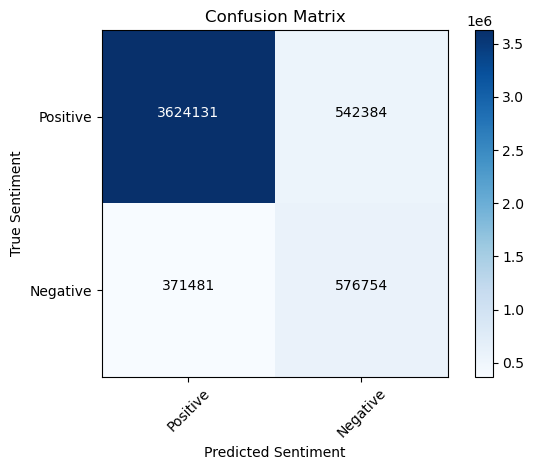

In [44]:
plt.xlabel('Predicted Sentiment')
plt.ylabel('True Sentiment')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

#### Data Analysis using SQL Queries

Average sentiment score for each product

In [112]:
sentiment_data.createOrReplaceTempView("data")

In [113]:
avg = spark.sql("""
    SELECT product_id, AVG(sentiment_score) as avg
    FROM data
    GROUP BY product_id""")

avg.show(10)

+----------+-------------------+
|product_id|                avg|
+----------+-------------------+
|B002771T86| 0.5075754363808715|
|B00A1WTQMU|0.44040000438690186|
|B000AADF20| 0.5085678560925382|
|B00F5KDIC2| 0.5649118926678155|
|B00JB6R7NM| 0.7181307840605137|
|B00M4P30RE|0.47506333254277705|
|B00742JW8S|0.31106039151252035|
|B0009YDO32| 0.6495153017627086|
|B003W91Z4G| 0.6730454503135248|
|B002K8MK0I| 0.5124503405523949|
+----------+-------------------+
only showing top 10 rows



Average sentiment score per review length

In [ ]:
review_length = spark.sql("""
    SELECT CASE
             WHEN length(review_body) < 50 THEN 'Very Short'
             WHEN length(review_body) < 100 THEN 'Short'
             WHEN length(review_body) < 500 THEN 'Medium'
             ELSE 'Long'
           END AS length,
           AVG(sentiment_score) as avg, COUNT(*) as review_number
    FROM data
    WHERE sentiment_score IS NOT NULL
    GROUP BY length
    ORDER BY avg DESC """)
review_length.show()

+----------+-------------------+-------------+
|    length|                avg|review_number|
+----------+-------------------+-------------+
|      Long|  0.706793788987988|       627296|
|    Medium| 0.5593110847452611|      2886795|
|     Short| 0.4683143967242185|       625546|
|Very Short|0.43135135939359054|       975113|
+----------+-------------------+-------------+



Top 10 products with highest average sentiment score

In [ ]:
top = spark.sql("SELECT product_id, AVG(sentiment_score) FROM data GROUP BY product_id ORDER BY AVG(sentiment_score) DESC LIMIT 10")
top.show()

+----------+--------------------+
|product_id|avg(sentiment_score)|
+----------+--------------------+
|B000WAYCFM|  0.9998999834060669|
|B000WAVII6|  0.9998999834060669|
|B003URC9WM|  0.9998000264167786|
|B000MPCUJ2|  0.9998000264167786|
|B00GYG3IYE|  0.9997000098228455|
|B00TK8M3DA|  0.9997000098228455|
|B0047D3SWI|  0.9997000098228455|
|B001FTSQGK|  0.9997000098228455|
|B001HDIMP4|  0.9997000098228455|
|B00AQ2SC6G|  0.9997000098228455|
+----------+--------------------+



Get the average sentiment score and star rating for each product, and calculate the correlation between the two:

In [ ]:
sen_rat = spark.sql("SELECT product_id, AVG(sentiment_score) AS avg, AVG(star_rating) AS rat FROM data GROUP BY product_id")
sen_rat.createOrReplaceTempView("sen_rat")
corr = spark.sql("SELECT corr(avg, rat) FROM sen_rat").collect()[0][0]
print(corr)

0.5900797217014696


Calculate the average sentiment score for each year:

In [ ]:
date = spark.sql("SELECT *, to_date(review_date, 'yyyy-MM-dd') AS datee, year(to_date(review_date, 'yyyy-MM-dd')) AS year FROM data")
date.createOrReplaceTempView("date")
avg = spark.sql("SELECT year, AVG(sentiment_score) AS avg_score FROM date GROUP BY year")
avg.show()

In [ ]:
avg = spark.sql("SELECT year, AVG(sentiment_score) AS avg_score FROM date GROUP BY year")
avg.show()

+----+------------------+
|year|         avg_score|
+----+------------------+
|2015|0.5105116464445112|
|null|               0.0|
|2013|0.5765571339099564|
|2007|0.6092394858450527|
|2006|0.6074771794274715|
|2003|0.5585404957864827|
|2014|0.5300073821068414|
|2012|  0.59577999370258|
|2010|0.5937533204835626|
|2011|0.6024472529493059|
|2009|0.5984136476895681|
|2005|0.6215862085947389|
|2008|0.6174625692854941|
|2004|0.6138556047663667|
|2001| 0.586950973520628|
|2000|0.7279333361622059|
|2002|0.5457814806925274|
+----+------------------+



In [37]:
revrdd = true_sentiment_data.select('true_sentiment', 'review_body').rdd
revrdd2 = revrdd..map(lambda x: (x['true_sentiment'], (len(x['review_body']), 1))).reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])).mapValues(lambda x: x[0] / x[1])
avg_len = revrdd2.collect()
print(avg_len)

Sentiment: positive, Average Length: 234.81696741894683
Sentiment: neutral, Average Length: 280.64336924760767
Sentiment: negative, Average Length: 286.3778805972191


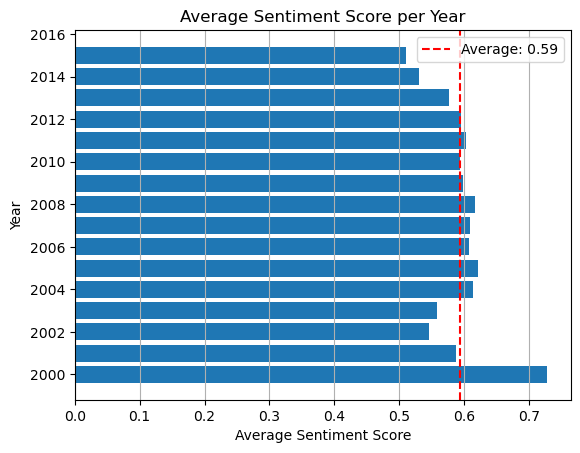

In [33]:
plt.barh(years, avg)
plt.xlabel("Average Sentiment Score")
plt.ylabel("Year")
plt.title("Average Sentiment Score per Year")
plt.show()

#### Creating wordclouds

In [9]:
stop = set(stopwords.words('english'))

def filter_text(text):
    tokens = re.findall(r'\b\w+\b', text)
    filtered = [word for word in tokens if word.lower() not in stop]
    return filtered

filter_text = udf(filter_text, ArrayType(StringType()))

sen_data = sentiment_data.withColumn('tokenized_text', filter_text(col('review_body')))

In [11]:
sen_data = sen_data.withColumn('sentiment_label', (col('sentiment_score') > 0.2).cast('integer'))

pos_rev = sen_data.filter(col('sentiment_label') == 1).select('review_body').rdd.map(lambda x: x[0]).filter(lambda x: x is not None).map(filter_text)
neg_rev = sen_data.filter(col('sentiment_label') == 0).select('review_body').rdd.map(lambda x: x[0]).filter(lambda x: x is not None).map(filter_text)

In [ ]:
pos_frequencies = pos_rev.flatMap(lambda x: x).countByValue()

In [14]:
neg_frequencies = neg_rev.flatMap(lambda x: x).countByValue()

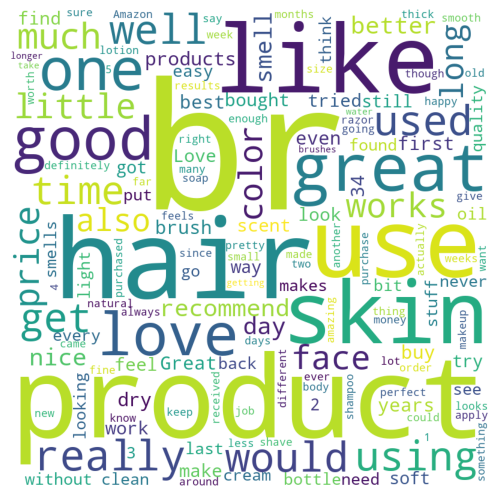

In [19]:
wordcloud = WordCloud(background_color="white", width=800, height=800, max_words=150).generate_from_frequencies(pos_frequencies)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

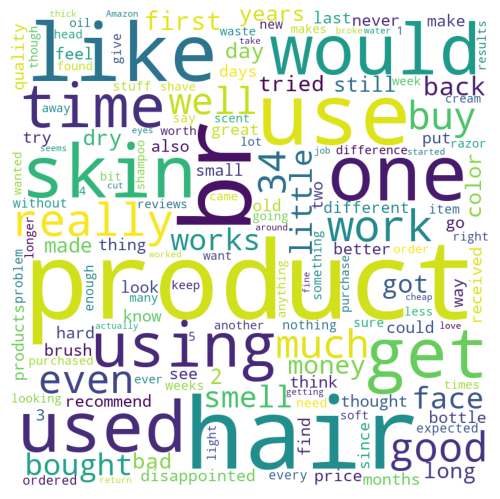

In [20]:
wordcloud = WordCloud(background_color="white", width=800, height=800, max_words=150).generate_from_frequencies(neg_frequencies)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Prediction

This function is taken directly from https://github.com/jesseqzhen/NLP_Sentiment_Analysis_-Spark-/blob/master/nlp_json.ipynb

In [14]:
def clean(text):
    
    line = html.unescape(text)
    line = line.replace("can't", 'can not')
    line = line.replace("n't", " not")
    pad_punct = str.maketrans({key: " {0} ".format(key) for key in string.punctuation}) 
    line = line.translate(pad_punct)
    line = line.lower()
    line = line.split() 
    lemmatizer = nltk.WordNetLemmatizer()
    line = [lemmatizer.lemmatize(t) for t in line] 
    
    tokens = []
    negated = False
    for t in line:
        if t in ['not', 'no']:
            negated = not negated
        elif t in string.punctuation or not t.isalpha():
            negated = False
        else:
            tokens.append('not_' + t if negated else t)
    
    invalidChars = str(string.punctuation.replace("_", ""))  
    bi_tokens = list(nltk.bigrams(line))
    bi_tokens = list(map('_'.join, bi_tokens))
    bi_tokens = [i for i in bi_tokens if all(j not in invalidChars for j in i)]
    tri_tokens = list(nltk.trigrams(line))
    tri_tokens = list(map('_'.join, tri_tokens))
    tri_tokens = [i for i in tri_tokens if all(j not in invalidChars for j in i)]
    tokens = tokens + bi_tokens + tri_tokens      
    
    return tokens

In [15]:
get_tokens = udf(clean, ArrayType(StringType()))
tokens = true_sentiment_data.withColumn('tokens', get_tokens(col('review_body')))
tokens.show(3)

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------------+---------------+--------------+-----+--------------------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|sentiment_score|sentiment_class|true_sentiment|label|              tokens|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+---------------+---------------+--------------+-----+--------------------+
|         US|    1797882|R3I2DHQBR577SS|B001ANOOOE|       2102612|The Naked Bee Vit...|          Beauty|          5|  

Take equal sample for both positive and negative reviews

In [17]:
pos = tokens.where('label=0').sample(False, 0.05, seed=90)
neg = tokens.where('label=1').sample(False, 0.20, seed=90)
data = pos.union(neg).select('label', 'review_body', 'tokens')

In [18]:
training, testing = data.randomSplit([0.7,0.3], seed=3)

In [19]:
training.cache()

DataFrame[label: int, review_body: string, tokens: array<string>]

##### Naive Bayes non CV model

In [35]:
vec = CountVectorizer(inputCol='tokens', outputCol='c_vec', minDF=4.0)
idf = IDF(inputCol="c_vec", outputCol="features")

In [ ]:
naivebayes = NaiveBayes()
pipeline_naivebayes = Pipeline(stages=[vec, idf, naivebayes])
model_naivebayes = pipeline_naivebayes.fit(training)
test_naivebayes = model_naivebayes.transform(testing)

In [37]:
roc_naivebayes_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')
roc_naivebayes = roc_naivebayes_eval.evaluate(test_naivebayes)
print(roc_naivebayes)

ROC of the NB model: 0.8886367031488226


In [38]:
acc_naivebayes_eval = MulticlassClassificationEvaluator(metricName='accuracy')
acc_naivebayes = acc_naivebayes_eval.evaluate(test_naivebayes)
print(acc_naivebayes)

Accuracy of the NB model: 0.888480604296168


###### Naive Bayes with CV model

In [ ]:
paramGrid_naivebayes = (ParamGridBuilder()
                .addGrid(vec.minDF, [3.0, 5.0, 7.0, 10.0, 15.0])
                .addGrid(naivebayes.smoothing, [0.1, 0.5, 1.0])
                .build())
cv_naivebayes = CrossValidator(estimator=pipeline_naivebayes, estimatorParamMaps=paramGrid_naivebayes, evaluator=acc_naivebayes_eval, numFolds=5)
cv_model_naivebayes = cv_naivebayes.fit(training) 

In [ ]:
test_cv_naivebayes = cv_model_naivebayes.transform(testing)
acc_naivebayes_cv = acc_naivebayes_eval.evaluate(test_cv_naivebayes)
print(acc_naivebayes_cv)

Accuracy of the NB CV model: 0.8886222362105595


##### Logistic Regressions nonCV model

In [22]:
logreg = LogisticRegression(maxIter=5)
pipeline_logreg = Pipeline(stages=[vec, idf, logreg])
model_logreg = pipeline_logreg.fit(training)
test_logreg = model_logreg.transform(testing)

In [ ]:
roc_logreg_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')
roc_logreg = roc_logreg_eval.evaluate(test_logreg)
print(roc_logreg)

ROC of the model: 0.8949793101508788


In [ ]:
acc_logreg_eval = MulticlassClassificationEvaluator(metricName='accuracy')
acc_logreg = acc_logreg_eval.evaluate(test_logreg)
print(acc_logreg)

Accuracy of the model: 0.8964119915020852


###### Linear SVC Model

In [ ]:
linsvc = LinearSVC(maxIter=5)
pipeline_linsvc = Pipeline(stages=[vec, idf, linsvc])
model_linsvc = pipeline_linsvc.fit(training)
test_linsvc = model_linsvc.transform(testing)

In [ ]:
roc_linsvc_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')
roc_linsvc = roc_linsvc_eval.evaluate(test_linsvc)
print(roc_linsvc)

ROC of the model: 0.9019661233944156


In [ ]:
acc_linsvc_eval = MulticlassClassificationEvaluator(metricName='accuracy')
acc_linsvc = acc_linsvc_eval.evaluate(test_linsvc)
print(acc_linsvc)

Accuracy of the model: 0.9022267684318199


In [ ]:
acc_linsvc_eval = MulticlassClassificationEvaluator(metricName='accuracy')

###### Logistic Regression CV Model

In [ ]:
paramGrid_logreg = (ParamGridBuilder()
                 .addGrid(vec.minDF, [3.0, 5.0, 7.0, 10.0, 15.0])
                 .addGrid(logreg.regParam, [0.01, 0.1, 0.5, 1.0])
                 .addGrid(logreg.elasticNetParam, [0.0, 0.5, 1.0])
                 .build())

cv_logreg = CrossValidator(estimator=pipeline_logreg, estimatorParamMaps=paramGrid_logreg, evaluator=acc_logreg_eval, numFolds=4)
cv_model_logreg = cv_logreg.fit(training)

23/04/22 19:48:08 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/04/22 19:48:08 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [ ]:
test_cv_logreg = cv_model_logreg.transform(testing)
acc_logreg_cv = acc_logreg_eval.evaluate(test_cv_logreg)
print(acc_logreg_cv)

Accuracy of the LGR CV model: 0.8953654890235266


{Param(parent='LogisticRegression_9f32c4ebc303', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_9f32c4ebc303', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LogisticRegression_9f32c4ebc303', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto',
 Param(parent='LogisticRegression_9f32c4ebc303', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LogisticRegression_9f32c4ebc303', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LogisticRegression_9f32c4ebc303', name='labelCol', doc='label column name.'): 'label',
 Param(parent='LogisticRegression_9f32c4ebc303', name='maxBlockSizeInMB', doc='maximum memory in MB for s

###### Linear SVC CV Model

In [ ]:
paramGrid_linsvc = (ParamGridBuilder()
                  .addGrid(vec.minDF, [3.0, 5.0, 7.0, 10.0, 15.0])
                  .addGrid(linsvc.regParam, [0.01, 0.1, 0.5, 1.0])
                  .build())

cv_linsvc = CrossValidator(estimator=pipeline_linsvc, estimatorParamMaps=paramGrid_linsvc, evaluator=acc_linsvc_eval, numFolds=5)
cv_model_linsvc = cv_linsvc.fit(training)

In [ ]:
test_cv_linsvc = cv_model_linsvc.transform(testing)
acc_linsvc_cv = acc_linsvc_eval.evaluate(test_cv_linsvc)
print(acc_linsvc_cv)

Accuracy of the LSVC CV model: 0.902533637579668


###### NonCV vs CV Models

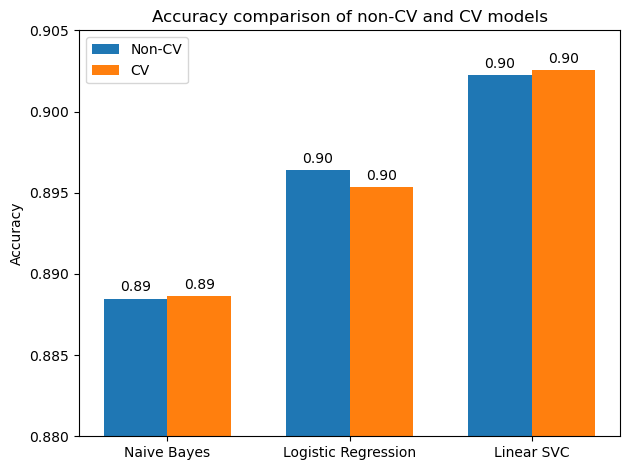

In [18]:
title = ['Naive Bayes', 'Logistic Regression', 'Linear SVC']
noncv = [acc_naivebayes, acc_logreg, acc_linsvc]
cv = [acc_naivebayes_cv, acc_logreg_cv, acc_linsvc_cv]

le = np.arange(len(title))
width = 0.4

fig, axis = plt.subplots()
r = ax.bar(le - width/2, noncv, width, label='Non-CV')
s = ax.bar(le + width/2, cv, width, label='CV')

axis.set_ylabel('Accuracy')
axis.set_title('Accuracy comparison of non-CV and CV models')
axis.set_xticks(le)
axis.set_xticklabels(title)
axis.set_ylim(0.88, 0.905)
axis.legend()

##### Comparing nonCV models 

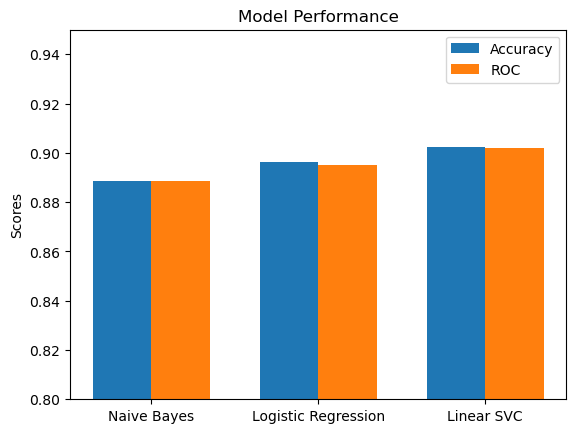

In [49]:
title = ['Naive Bayes', 'Logistic Regression', 'Linear SVC']
acc = [acc_naivebayes, acc_logreg, acc_linsvc]
roc = [roc_naivebayes, roc_logreg, roc_linsvc]

fig, axis = plt.subplots()
r = ax.bar(le - width/2, acc, width, label='Accuracy')
s = ax.bar(le + width/2, roc, width, label='ROC')

axis.set_ylabel('Scores')
axis.set_title('Model Performance')
axis.set_xticks(le)
axis.set_xticklabels(models)
axis.legend()
axis.set_ylim(0.8, 0.95)
plt.show()

## Recommendation

#### Content-based recommendation

Getting all the reviews together for each product

In [22]:
all_reviews = amazon_data.groupBy("product_id").agg(F.collect_list("review_body").alias("all_reviews")).withColumn("reviews_text", F.concat_ws(" ", "all_reviews"))

Extract features from the product reviews using TF-IDF

In [23]:
t = Tokenizer(inputCol="reviews_text", outputCol="tokens")
rev_token = t.transform(all_reviews)

has = HashingTF(inputCol="tokens", outputCol="raw", numFeatures=1000)
feature = has.transform(rev_token)

idf = IDF(inputCol="raw", outputCol="features")
new = idf.fit(feature)
final_data = new.transform(feature)

In [ ]:
def cos_sim(arr1, arr2):
    arr1_np = np.array(arr1)
    arr2_np = np.array(arr2)
    dot_product = np.dot(arr1_np, arr2_np)
    norm_product = np.linalg.norm(arr1_np) * np.linalg.norm(arr2_np)
    return float(dot_product / norm_product)

cos_sim = F.udf(cos_sim, FloatType())

Convert features to feature array to perform cosine similarity

In [ ]:
def extract(v):
    if isinstance(arr, SparseVector):
        arr = arr.toArray()
    return arr.tolist()

extract_udf = F.udf(extract, ArrayType(FloatType()))

In [ ]:
final_data = final_data.withColumn("vector", extract_udf(F.col("features")))

Performing cosine similarity

In [ ]:
def cos_sim_rec(product_id, recc):
    target_product = final_data.filter(col("product_id") == product_id).select("vector").first()
    
    if target_product is None:
        print("none")
        return None
    
    target_features = Vectors.dense(target_product["vector"])
    
    recommendations = final_data.withColumn("cosine_sim", cos_sim(col("vector"), F.array(*[F.lit(x) for x in target_features]))) \
        .filter(col("product_id") != product_id) \
        .select("product_id", "cosine_sim") \
        .orderBy(desc("cosine_sim")) \
        .limit(recc)
    
    return recommendations

In [24]:
product_id = "B001MA0QY2"
recc = 10
final_rec = cos_sim_rec(product_id, recc)
final_rec.show()

+----------+----------+
|product_id|similarity|
+----------+----------+
|B00N30SE3E| 0.9757761|
|B00B76ALVO| 0.9543328|
|B004INQ65S|0.94657975|
|B0009XH6SC|0.93763614|
|B00BB8ZIRK|0.93135357|
|B007ZXR4I6|0.92609286|
|B000R8715M| 0.9225896|
|B002LIXTFC| 0.9220803|
|B00497BELY|  0.919404|
|B008U5XS2O| 0.9184702|
+----------+----------+



###### Collaborative filtering model

Converting customer ids and product ids as integer indices

In [ ]:
index1 = StringIndexer(inputCol="customer_id", outputCol="idx1")
index2 = StringIndexer(inputCol="product_id", outputCol="idx2")

In [ ]:
pipeline = Pipeline(stages=[index1, index2])
data_rec = pipeline.fit(true_sentiment_data).transform(true_sentiment_data)
data_rec = data_rec.select("idx1", "idx2", "star_rating")

In [ ]:
als = ALS(rank=10, maxIter=10, regParam=0.1, userCol="idx1", itemCol="idx2", ratingCol="star_rating", coldStartStrategy="drop", nonnegative=True, seed=2)
model = als.fit(data_rec)

Calculating RMSE for this model

In [ ]:
(training, test) = data_rec.randomSplit([0.7, 0.3], seed=2)
model = als.fit(training)

In [ ]:
predictions = model.transform(test)
predictions = predictions.na.drop()

In [ ]:
error = RegressionEvaluator(metricName="rmse", labelCol="star_rating",
                                predictionCol="prediction")

Root Mean Square Error for ALS model

In [17]:
rmse = error.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.7567636322027766


Top 10 recommendations for all customers

In [ ]:
customer = model.recommendForAllUsers(10)
customer.show(truncate=False)

+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|customer_idx|recommendations                                                                                                                                                                                                     |
+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|31          |[{296429, 16.328068}, {483865, 15.901779}, {286438, 15.740509}, {202136, 15.664841}, {201398, 15.634038}, {254428, 15.38573}, {242095, 15.29113}, {149967, 15.233497}, {304100, 15.197423}, {276113, 15.099527}]    |
|85          |[{483865, 12.042213}, {296429, 11.623461}, {202136, 11.576259}, {201398, 1

Top 10 recommendations for products

In [ ]:
product = model.recommendForAllItems(10)
product.show(truncate=False)

+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|product_idx|recommendations                                                                                                                                                                                                     |
+-----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|28         |[{22784, 6.7630925}, {681443, 6.605016}, {390134, 6.5727863}, {171080, 6.474584}, {2427886, 6.4454412}, {128215, 6.4224963}, {107517, 6.4210343}, {274806, 6.37417}, {146281, 6.3597517}, {341441, 6.353771}]       |
|31         |[{433523, 5.816883}, {345642, 5.7632327}, {304699, 5.7548704}, {2655778, 5.7484